In [1]:
import timeit
import numpy
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [6, 4]
pyplot.rcParams['figure.dpi'] = 200

Let's consider a simple linear regression optimization problem over $\mathbb{R}^d$ with objective function

$$ f(w; x_i, y_i) = \frac{1}{2} (x_i^T w - y_i)^2 $$

Here, the gradient is

$$ \nabla f(w; x_i, y_i) = x_i (x_i^T w - y_i).$$

We suppose that we have a dataset of $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, giving us a total empirical risk

$$
    f(w) = \frac{1}{n} \sum_{i=1}^n f(w; x_i, y_i) = \frac{1}{n} \sum_{i=1}^n (x_i^T w - y_i)^2.
$$

The gradient of this is

\begin{align*}
    \nabla f(w) 
    &= 
    \frac{1}{n} \sum_{i=1}^n \nabla f(w; x_i, y_i) 
    \\&=
    \frac{1}{n} \sum_{i=1}^n  x_i (x_i^T w - y_i)
    \\&=
    \left( \frac{1}{n} \sum_{i=1}^n x_i x_i^T \right) w - \frac{1}{n} \sum_{i=1}^n  x_i y_i.
\end{align*}
Of course, the exact minimum occurs when the gradient is $0$, at
$$
    w = \left( \frac{1}{n} \sum_{i=1}^n x_i x_i^T \right)^{-1} \left( \frac{1}{n} \sum_{i=1}^n  x_i y_i \right).
$$

In [2]:
# lets generate a synthetic dataset, first for the simple case of d = 1.
d = 1;
n = 1024;
X = numpy.random.randn(d, n);
Y = numpy.random.randn(n);

In [3]:
# find the true optimum
# there are more numerically accurate ways of solving (this is just for simplicity)
A = sum(X[:,i:(i+1)] @ X[:,i:(i+1)].T for i in range(n)) / n;
b = sum(X[:,i]*Y[i] for i in range(n)) / n;
w_opt = numpy.linalg.inv(A) @ b;

In [4]:
# component loss function
def loss_fi(w, xi, yi):
    return (numpy.dot(xi,w) - yi)**2/2

# component gradient function
def grad_fi(w, xi, yi):
    return xi * (numpy.dot(xi,w) - yi)

# total loss function
def loss_f(w, X, Y):
    (d, n) = X.shape
    return sum(loss_fi(w, X[:,i], Y[i]) for i in range(n)) / n

# total gradient function
def grad_f(w, X, Y):
    (d,n) = X.shape
    return sum(grad_fi(w, X[:,i], Y[i]) for i in range(n)) / n

Observe that we can write this loss function and gradient function in terms of matrix operations...which is equivalent and much faster to run! (This is one of the first examples of a systems trick that we can do to make our learning algorithm more scalable...and something you've probably already seen.)

In [5]:
# total loss function
def matrix_loss_f(w, X, Y):
    (d,n) = X.shape
    return numpy.sum((X.T @ w - Y)**2) / (2*n);

# total gradient function
def matrix_grad_f(w, X, Y):
    return X @ (X.T @ w - Y) / n;

In [6]:
w = numpy.random.randn(d);

print(loss_f(w, X, Y));
print(matrix_loss_f(w, X, Y));

print(grad_f(w, X, Y));
print(matrix_grad_f(w, X, Y));

print("these functions agree!")

1.827423868245188
1.8274238682451869
[1.70229262]
[1.70229262]
these functions agree!


### The matrix version is _much_ faster! Almost 500x faster

In [7]:
%timeit grad_f(w, X, Y)
%timeit matrix_grad_f(w, X, Y)

3.7 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.15 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
# and this still holds for larger dimensions
X32 = numpy.random.randn(32, n);
Y32 = numpy.random.randn(n);
%timeit grad_f(w, X, Y)
%timeit matrix_grad_f(w, X, Y)

3.76 ms ± 97.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.13 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Now let's look at what GD and SGD do. Here, we'll measure the distance to the (known) optimum at each step.

In [9]:
def gradient_descent(w0, X, Y, w_opt, alpha, num_iters):
    # array to save the distance-to-optimum at each step
    dist_to_optimum = numpy.zeros(num_iters)
    # array to save the loss value at each step
    loss = numpy.zeros(num_iters)
    w = w0
    for t in range(num_iters):
        w = w - alpha * matrix_grad_f(w, X, Y)
        dist_to_optimum[t] = numpy.linalg.norm(w - w_opt)
        loss[t] = matrix_loss_f(w, X, Y)
    return (dist_to_optimum, loss)

def stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters):
    (d,n) = X.shape
    # array to save the distance-to-optimum at each step
    dist_to_optimum = numpy.zeros(num_iters)
    # array to save the loss value at each step
    loss = numpy.zeros(num_iters)
    w = w0
    for t in range(num_iters):
        i = numpy.random.randint(n)
        w = w - alpha * grad_fi(w, X[:,i], Y[i])
        dist_to_optimum[t] = numpy.linalg.norm(w - w_opt)
        loss[t] = matrix_loss_f(w, X, Y)
    return (dist_to_optimum, loss)

In [10]:
w0 = 5.0 * numpy.ones(d);
alpha = 0.1;
num_iters = 1000;
(gd_dist, gd_loss) = gradient_descent(w0, X, Y, w_opt, alpha, num_iters);
(sgd_dist, sgd_loss) = stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters);

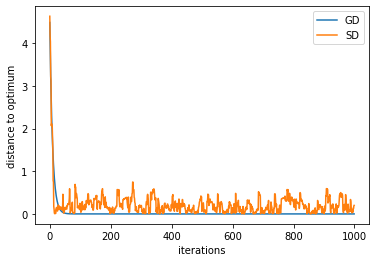

In [11]:
pyplot.plot(numpy.arange(num_iters), gd_dist, label="GD");
pyplot.plot(numpy.arange(num_iters), sgd_dist, label="SD")
pyplot.xlabel("iterations");
pyplot.ylabel("distance to optimum");
pyplot.legend();

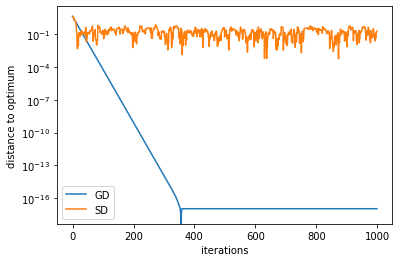

In [12]:
pyplot.semilogy(numpy.arange(num_iters), gd_dist, label="GD");
pyplot.semilogy(numpy.arange(num_iters), sgd_dist, label="SD")
pyplot.xlabel("iterations");
pyplot.ylabel("distance to optimum");
pyplot.legend();

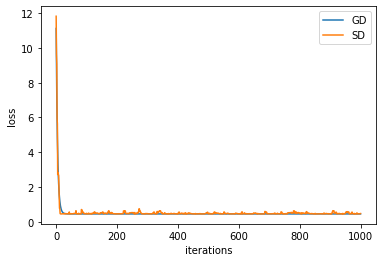

In [13]:
pyplot.plot(numpy.arange(num_iters), gd_loss, label="GD");
pyplot.plot(numpy.arange(num_iters), sgd_loss, label="SD")
pyplot.xlabel("iterations");
pyplot.ylabel("loss");
pyplot.legend();

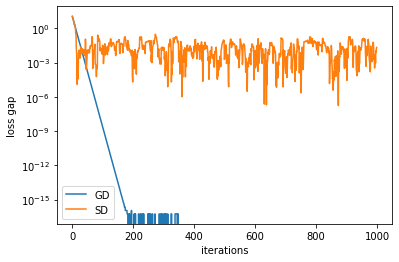

In [14]:
pyplot.semilogy(numpy.arange(num_iters), gd_loss - matrix_loss_f(w_opt, X, Y), label="GD");
pyplot.semilogy(numpy.arange(num_iters), sgd_loss - matrix_loss_f(w_opt, X, Y), label="SD")
pyplot.xlabel("iterations");
pyplot.ylabel("loss gap");
pyplot.legend();

### Let's try something with a higher dimension!

In [15]:
# lets generate a synthetic dataset, now for d = 100
d = 100;
n = 1024;
X = numpy.random.randn(d, n);
Y = numpy.random.randn(n);

# find the true optimum
# there are more numerically accurate ways of solving (this is just for simplicity)
A = sum(X[:,i:(i+1)] @ X[:,i:(i+1)].T for i in range(n)) / n;
b = sum(X[:,i]*Y[i] for i in range(n)) / n;
w_opt = numpy.linalg.inv(A) @ b;

In [16]:
w0 = 2 * numpy.random.randn(d);
alpha = 0.01;
num_iters = 5000;
(gd_dist, gd_loss) = gradient_descent(w0, X, Y, w_opt, alpha, num_iters);
(sgd_dist, sgd_loss) = stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters);
(sgd_dist2, sgd_loss2) = stochastic_gradient_descent(w0, X, Y, w_opt, 0.5 * alpha, num_iters);

In [17]:
%timeit (gd_dist, gd_loss) = gradient_descent(w0, X, Y, w_opt, alpha, num_iters);
%timeit (sgd_dist, sgd_loss) = stochastic_gradient_descent(w0, X, Y, w_opt, alpha, num_iters);

365 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
288 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


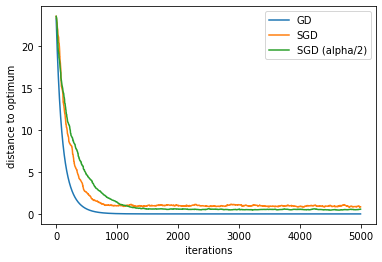

In [18]:
pyplot.plot(numpy.arange(num_iters), gd_dist, label="GD");
pyplot.plot(numpy.arange(num_iters), sgd_dist, label="SGD");
pyplot.plot(numpy.arange(num_iters), sgd_dist2, label="SGD (alpha/2)")
pyplot.xlabel("iterations");
pyplot.ylabel("distance to optimum");
pyplot.legend();

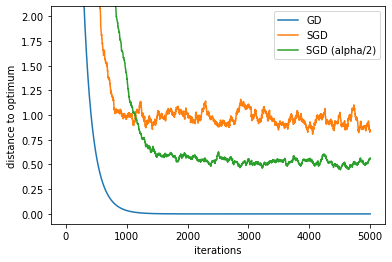

In [19]:
# same thing, but zoomed in
pyplot.plot(numpy.arange(num_iters), gd_dist, label="GD");
pyplot.plot(numpy.arange(num_iters), sgd_dist, label="SGD");
pyplot.plot(numpy.arange(num_iters), sgd_dist2, label="SGD (alpha/2)")
pyplot.xlabel("iterations");
pyplot.ylabel("distance to optimum");
pyplot.legend();
pyplot.ylim([-0.1,2.1]);

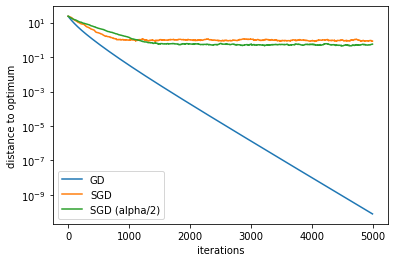

In [20]:
pyplot.semilogy(numpy.arange(num_iters), gd_dist, label="GD");
pyplot.semilogy(numpy.arange(num_iters), sgd_dist, label="SGD");
pyplot.semilogy(numpy.arange(num_iters), sgd_dist2, label="SGD (alpha/2)")
pyplot.xlabel("iterations");
pyplot.ylabel("distance to optimum");
pyplot.legend();

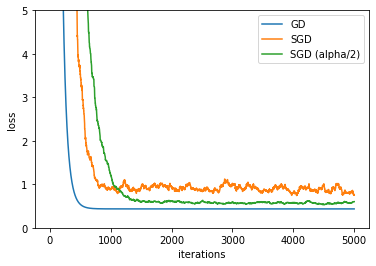

In [21]:
pyplot.plot(numpy.arange(num_iters), gd_loss, label="GD");
pyplot.plot(numpy.arange(num_iters), sgd_loss, label="SGD");
pyplot.plot(numpy.arange(num_iters), sgd_loss2, label="SGD (alpha/2)")
pyplot.xlabel("iterations");
pyplot.ylabel("loss");
pyplot.legend();
pyplot.ylim((0,5));

# What does this tell us about the convergence of SGD?

In [22]:
[numpy.abs(numpy.random.randn()) for i in range(16)]

[0.7747063527978051,
 1.057500405201921,
 1.6176709951257424,
 1.2409923115225703,
 0.4003199592566089,
 0.36279790348756713,
 0.09025590117876164,
 1.8044971280028936,
 0.40115710703888063,
 0.3547651998594488,
 0.6146310924566338,
 0.28410523853811404,
 0.7669581281228256,
 2.6408671475594367,
 1.7194504453004142,
 0.35968898270857247]

In [23]:
[numpy.linalg.norm(numpy.random.randn(1000)) for i in range(16)]

[32.395785891280774,
 32.41303910154269,
 31.4965107583724,
 30.819989078492082,
 32.276372884141345,
 31.077575138276327,
 32.001698669884746,
 30.870415720320292,
 31.609458137002168,
 32.53134486451919,
 31.92299613840642,
 32.57911787194603,
 30.395735911945575,
 30.436598670321004,
 31.494249440607494,
 30.98130921962293]

### Concentration of norms in high dimensions can make SGD "look" converged even when it's not close to the optimum.

* This is because in high dimensions, the vast majority of the volume of the $d$-dimensional ball lies near its surface.
* This means that a highly "noisy" SGD trajectory that is just bouncing around in the interior of a $d$-dimensional ball can still look like it's converged.